In [37]:
import pandas
from sklearn import (decomposition, preprocessing)
import numpy
import flowio
import seaborn
import matplotlib.pyplot as plt

In [38]:
fcs_data = flowio.FlowData('features.fcs')
npy_data = numpy.reshape(fcs_data.events, (-1, fcs_data.channel_count))
df = pandas.DataFrame(npy_data, columns=[c["PnN"] for c in fcs_data.channels.values()])

In [39]:
df.columns = ["feat_%s" % col if col not in ["set", "label"] else "meta_%s" % col for col in df]
df["index"] = numpy.arange(df.shape[0])

In [40]:
df = df[df["meta_label"] != -1]

In [81]:
df = df.drop(columns=(df.columns[df.var() == 0]))
df = df.drop(columns=df.filter(regex="saturation").columns)

In [135]:
dfs = []
for idx, gdf in df.groupby("meta_set"):
    X = gdf.drop(columns=["meta_set", "meta_label"])
    tmp_df = pandas.DataFrame(preprocessing.StandardScaler().fit_transform(X), columns=X.columns)
    tmp_df["meta_set"] = gdf["meta_set"].values
    tmp_df["meta_label"] = gdf["meta_label"].values
    dfs.append(tmp_df)
scaled_df = pandas.concat(dfs)
scaled_df.loc[trans_df["meta_set"] == 100, "meta_set"] = 1

In [136]:
embed_df = pandas.DataFrame(index=df.index)

In [137]:
tmp = decomposition.PCA(n_components=2).fit_transform(scaled_df.drop(columns=["meta_set", "meta_label"]).values)
embed_df["feat_pca_0"] = tmp[:, 0]
embed_df["feat_pca_1"] = tmp[:, 1]

<AxesSubplot:xlabel='feat_pca_0', ylabel='feat_pca_1'>

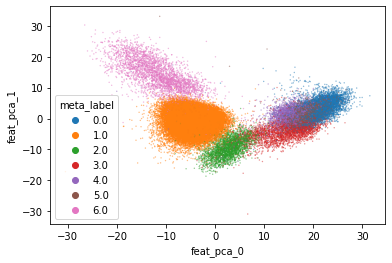

In [138]:
seaborn.scatterplot(data=pandas.concat([embed_df, df], axis=1), hue="meta_label", x="feat_pca_0", y="feat_pca_1", s=2, alpha=0.5, linewidth=0, palette="tab10")

<AxesSubplot:xlabel='feat_pca_0', ylabel='feat_pca_1'>

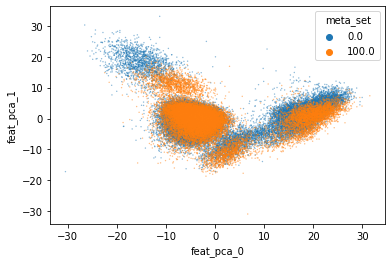

In [139]:
seaborn.scatterplot(data=pandas.concat([embed_df, df], axis=1), hue="meta_set", x="feat_pca_0", y="feat_pca_1", s=2, alpha=0.5, linewidth=0, palette="tab10")

In [147]:
export_df = pandas.concat([embed_df[["feat_pca_0", "feat_pca_1"]], df], axis=1)
for col in export_df:
    if(export_df[col].dtype == numpy.int64):
        export_df[col] = export_df[col].astype(numpy.int32)

export_df.reset_index(drop=True).to_feather("./demo_wbc.feather", compression="uncompressed")

ImportError: Missing optional dependency 'pyarrow'.  Use pip or conda to install pyarrow.

In [91]:
import umap

In [140]:
dfs = []
for idx, gdf in df.groupby("meta_set"):
    X = gdf.drop(columns=["meta_set", "meta_label"])
    tmp_df = pandas.DataFrame(preprocessing.MinMaxScaler().fit_transform(X), columns=X.columns)
    tmp_df["meta_set"] = gdf["meta_set"].values
    tmp_df["meta_label"] = gdf["meta_label"].values
    dfs.append(tmp_df)
minmax_df = pandas.concat(dfs)
minmax_df.loc[minmax_df["meta_set"] == 100, "meta_set"] = 1

In [141]:
tmp = umap.UMAP(n_components=2).fit_transform(minmax_df.drop(columns=["meta_set", "meta_label"]).values)
embed_df["feat_umap_0"] = tmp[:, 0]
embed_df["feat_umap_1"] = tmp[:, 1]

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

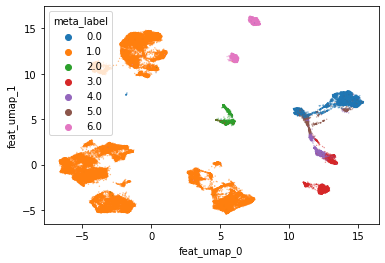

In [142]:
seaborn.scatterplot(data=pandas.concat([embed_df, df], axis=1), hue="meta_label", x="feat_umap_0", y="feat_umap_1", s=2, alpha=0.5, linewidth=0, palette="tab10")

<AxesSubplot:xlabel='feat_umap_0', ylabel='feat_umap_1'>

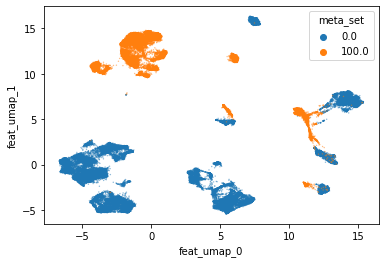

In [143]:
seaborn.scatterplot(data=pandas.concat([embed_df, df], axis=1), hue="meta_set", x="feat_umap_0", y="feat_umap_1", s=2, alpha=0.5, linewidth=0, palette="tab10")

In [144]:
from sklearn.manifold import TSNE

In [12]:
tmp = TSNE().fit_transform(trans_df.drop(columns=["meta_set", "meta_label"]).values)
embed_df["feat_tsne_0"] = tmp[:, 0]
embed_df["feat_tsne_1"] = tmp[:, 1]

In [95]:
import pymde

In [97]:
tmp = pymde.preserve_neighbors(minmax_df.drop(columns=["meta_set", "meta_label"]).values, constraint=pymde.Standardized(), device="cuda", verbose=True).embed(verbose=True, max_iter=1000)
embed_df["feat_mde_nn_0"] = tmp[:, 0].cpu().numpy()
embed_df["feat_mde_nn_1"] = tmp[:, 1].cpu().numpy()

Jun 23 02:35:38 PM: Computing 15-nearest neighbors, with max_distance=None
Wed Jun 23 14:35:38 2021 Building RP forest with 22 trees
Wed Jun 23 14:35:39 2021 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Jun 23 02:35:43 PM: Computing quadratic initialization.
Jun 23 02:35:51 PM: Fitting a standardized embedding into R^2, for a graph with 80654 items and 1237533 edges.
Jun 23 02:35:51 PM: `embed` method parameters: eps=1.0e-05, max_iter=1000, memory_size=10
Jun 23 02:35:51 PM: iteration 0000 | distortion 0.324335 | residual norm 0.0633104 | step length 0.158729 | percent change 0.00250209
Jun 23 02:35:53 PM: iteration 0100 | distortion 0.124478 | residual norm 9.08275e-05 | step length 1.01 | percent change 2.28408e-05
Jun 23 02:35:56 PM: iteration 0200 | distortion 0.124478 | residual norm 9.08273e-05 | step length 1.01 | percent change 2.28407e-05
Jun 23 02:35:59 PM: iteration 0300 | distortion 0.124478 | residual norm 9.08274

<AxesSubplot:xlabel='feat_mde_nn_0', ylabel='feat_mde_nn_1'>

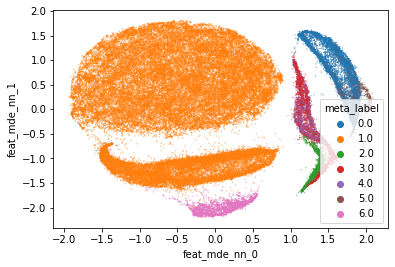

In [101]:
seaborn.scatterplot(data=pandas.concat([embed_df, trans_df], axis=1), hue="meta_label", x="feat_mde_nn_0", y="feat_mde_nn_1", s=2, alpha=0.5, linewidth=0, palette="tab10")

<AxesSubplot:xlabel='feat_mde_nn_0', ylabel='feat_mde_nn_1'>

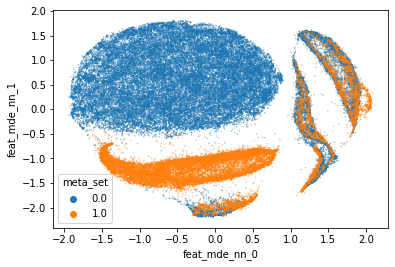

In [102]:
seaborn.scatterplot(data=pandas.concat([embed_df, trans_df], axis=1), hue="meta_set", x="feat_mde_nn_0", y="feat_mde_nn_1", s=2, alpha=0.5, linewidth=0, palette="tab10")

In [125]:
dists = pymde.preprocess.distances(trans_df.drop(columns=["meta_set", "meta_label"]).values, retain_fraction=0.001)

In [110]:
tmp = pymde.preserve_distances(trans_df.drop(columns=["meta_set", "meta_label"]).values, max_distances=100000, device="cuda", verbose=True).embed(verbose=True, max_iter=15000)

Jun 23 02:51:53 PM: Sampling 100000 edges
Jun 23 02:51:53 PM: Computing 100000 distances
Jun 23 02:51:53 PM: Fitting a centered embedding into R^2, for a graph with 80654 items and 100000 edges.
Jun 23 02:51:53 PM: `embed` method parameters: eps=1.0e-05, max_iter=15000, memory_size=10
Jun 23 02:51:53 PM: iteration 00000 | distortion 24.316170 | residual norm 0.00633883 | step length 534854 | percent change 845.51
Jun 23 02:51:59 PM: iteration 01500 | distortion 0.090868 | residual norm 0.00393949 | step length 1 | percent change 0.00376756
Jun 23 02:52:05 PM: iteration 03000 | distortion 0.064299 | residual norm 0.00395541 | step length 1 | percent change 0.00178535
Jun 23 02:52:10 PM: iteration 04500 | distortion 0.051435 | residual norm 0.00385004 | step length 1 | percent change 0.000366359
Jun 23 02:52:15 PM: iteration 06000 | distortion 0.048405 | residual norm 0.00391488 | step length 1 | percent change 0.00149101
Jun 23 02:52:21 PM: iteration 07500 | distortion 0.038305 | residu

In [111]:
embed_df["feat_mde_dist_0"] = tmp[:, 0].cpu().numpy()
embed_df["feat_mde_dist_1"] = tmp[:, 1].cpu().numpy()

<AxesSubplot:xlabel='feat_mde_dist_0', ylabel='feat_mde_dist_1'>

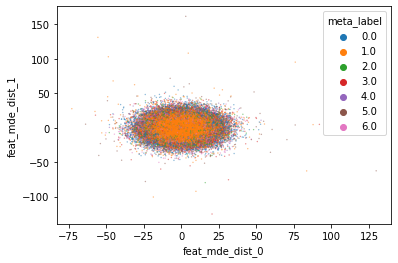

In [112]:
seaborn.scatterplot(data=pandas.concat([embed_df, trans_df], axis=1), hue="meta_label", x="feat_mde_dist_0", y="feat_mde_dist_1", s=2, alpha=0.5, linewidth=0, palette="tab10")

In [ ]:
fcs_data.text["class_labels"]

In [ ]:
seaborn.countplot(data=df, x="meta_label")

In [54]:
for col in trans_df:
    if(trans_df[col].dtype == numpy.int64):
        trans_df[col] = trans_df[col].astype(numpy.int32)

trans_df.reset_index(drop=True).to_feather("./demo_wbc.feather", compression="uncompressed")